# Imports

In [61]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Prepare Dataset

In [65]:
# Prepare Dataset
# load data
train = pd.read_csv(r"train.csv",dtype = np.float32) #42000 rows with 784 features and 1 target label

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values #42000 rows
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                            targets_numpy,
                                                                            test_size = 0.2,
                                                                            random_state = 42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
# 33600 rows for training set
featuresTrain = torch.tensor(features_train, requires_grad= True)
targetsTrain = torch.tensor(targets_train, requires_grad= True).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
# 8400 rows for test set
featuresTest = torch.tensor(features_test, requires_grad= True)
targetsTest = torch.tensor(targets_test, requires_grad= True).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
# 100 examples for each batch
# len(features_train) -> 33600 training examples
# Total number of batches -> 336
# epochs -> 1 whole cycle of training and updating parameters for all batches in the training dataset.
batch_size = 100
n_iters = 10000 # maximum number of iterations for whole code
num_epochs = n_iters / (len(features_train) / batch_size) # 10000 / (33600 / 100) = 29.7
num_epochs = int(num_epochs) #29

# Pytorch train and test sets - objects
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader - objects
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)


# Create ANN Model

In [66]:
# Create ANN Model
class ANNModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        
        # Linear function 1: 784 --> 150
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity 1
        self.relu1 = nn.ReLU()
        
        # Linear function 2: 150 --> 150
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        self.tanh2 = nn.Tanh()
        
        # Linear function 3: 150 --> 150
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3
        self.elu3 = nn.ELU()
        
        # Linear function 4 (readout): 150 --> 10
        self.fc4 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
        
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.tanh2(out)
        
        # Linear function 3
        out = self.fc3(out)
        # Non-linearity 3
        out = self.elu3(out)
        
        # Linear function 4 (readout)
        out = self.fc4(out)
        return out

# instantiate ANN
input_dim = 28*28 # 784 input neurons
hidden_dim = 150 # 150 neurons for each hidden layer
output_dim = 10 # 10 output neurons

# Create ANN object
model = ANNModel(input_dim, hidden_dim, output_dim)

# Cross Entropy Loss object
error = nn.CrossEntropyLoss()

# SGD Optimizer object
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train the Model

In [70]:
# ANN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(num_epochs): #num_epochs = 29
    
    # for every epoch: 
    # -> model runs trainings and update 336 batches (batch_size=100, training_size=33600)
    
    for i, (images, labels) in enumerate(train_loader):
        
        # batch_size    -> 100
        # i             -> i-th batch
        # images        -> 100 training examples, i.e., one batch of features
        # labels        -> 100 training labels, i.e., one batch of labels

        train = Variable(images.view(-1, 28*28))
        #train = images.view(-1, 28*28)
        labels = Variable(labels)
        
        # Clear gradients
        # optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. 
        # It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        # loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. 
        # These are accumulated into x.grad for every parameter x.
        # In pseudo-code: x.grad += dloss/dx
        loss.backward()
        
        # Update parameters
        # optimizer.step updates the value of x using the gradient x.grad. For example, the SGD optimizer performs:
        # x += -lr * x.grad
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader:

                test = Variable(images.view(-1, 28*28))
                #test = images.view(-1, 28*28)
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)

                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 0.7442542910575867  Accuracy: 79.10713958740234 %
Iteration: 1000  Loss: 0.4796392321586609  Accuracy: 87.73809814453125 %
Iteration: 1500  Loss: 0.22009025514125824  Accuracy: 89.67857360839844 %
Iteration: 2000  Loss: 0.289392352104187  Accuracy: 90.77381134033203 %
Iteration: 2500  Loss: 0.2871875464916229  Accuracy: 92.02381134033203 %
Iteration: 3000  Loss: 0.11839267611503601  Accuracy: 92.94047546386719 %
Iteration: 3500  Loss: 0.2673879563808441  Accuracy: 93.5952377319336 %
Iteration: 4000  Loss: 0.059466563165187836  Accuracy: 94.02381134033203 %
Iteration: 4500  Loss: 0.31288811564445496  Accuracy: 94.4047622680664 %
Iteration: 5000  Loss: 0.10666326433420181  Accuracy: 94.58333587646484 %
Iteration: 5500  Loss: 0.18090324103832245  Accuracy: 94.79762268066406 %
Iteration: 6000  Loss: 0.17860117554664612  Accuracy: 95.05952453613281 %
Iteration: 6500  Loss: 0.0901089683175087  Accuracy: 95.45237731933594 %
Iteration: 7000  Loss: 0.11291514337062836  Acc

# Plots

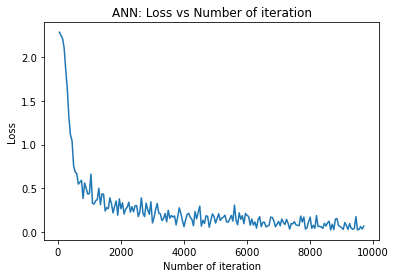

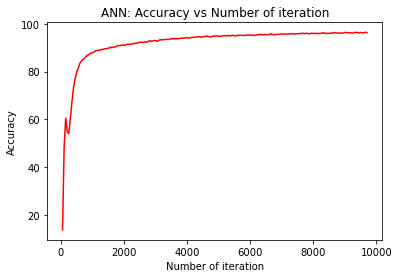

In [9]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()
